# Графики
## Сначала импортируем необходимые инструменты

In [1]:
import pandas as pd
import numpy as np

# Отключим предупреждения от Anaconda
import warnings
warnings.simplefilter('ignore')

%pylab inline
# Зададим стандартный размер фигур
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

import seaborn as sns # Seaborn

import matplotlib.pyplot as plt # Matplotlib
%matplotlib inline
# Графики в svg более четкие
%config InlineBackend.figure_format = 'svg' 

import plotly # Plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('rests.csv', index_col=0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 939 entries, 0 to 938
Data columns (total 5 columns):
restaurant           939 non-null object
cuisines             939 non-null object
average check        939 non-null int64
number of reviews    939 non-null int64
user's rating        939 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 44.0+ KB


,restaurant,cuisines,average check,number of reviews,user's rating
0,One Teaspoon,"Европейская,Подходит для вегетарианцев,Для вег...",1500,168,5.0
1,Verde cafe,"Современная,Подходит для вегетарианцев,Для вег...",1500,136,5.0
2,Русский паб | Russian pub,"Русская,Подходит для вегетарианцев,Для веганов",1500,84,5.0
3,"Практика by Darvin, Ленком","Итальянская,Средиземноморская,Европейская,Подх...",1500,127,5.0
4,Косой Маркс,"Бар,Паб",700,113,5.0


# Оставим записи, в которых нет пропусков, используя метод dropna

In [3]:
df = df.dropna()
print (df.shape)

(939, 5)


# 1. Какой средний чек встречается чаще всего?

Text(0.5,1,'Средний чек')

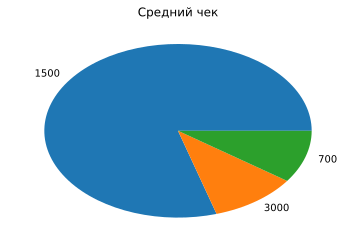

In [4]:
df["average check"].value_counts().plot(kind = 'pie', label = '')
plt.title('Средний чек')

# 2. Какие кухни наиболее популярны в Москве?
## Нужно помнить, что каждый ресторан может принадлежать к нескольким кухням

In [9]:
# str to list
if type(df['cuisines'][0]) is not list :
    df['cuisines'] = df['cuisines'].apply(lambda x: x.split(','))

df_as_list = df.to_dict(orient='records')

cuisines_data = []

'''
Распарсим столбец cuisines. 
Например: Чайхона №1 [Узбекская, Кавказская] => Чайхона №1 Узбекская
                                             => Чайхона №1 Кавказская
'''
for record in df_as_list:
    for cuisine in record['cuisines']:
        copy = record.copy()
        copy['cuisine'] = cuisine
        cuisines_data.append(copy)
        
cuisines_df = pd.DataFrame.from_dict(cuisines_data)

# Подсчитаем кол-во ресторанов и суммарное кол-во отзывов на каждом направлении кухни.
top10 = cuisines_df.groupby('cuisine')[['restaurant']].count().join(
    cuisines_df.groupby('cuisine')[['number of reviews']].sum())

top10 = top10.sort_values('restaurant', ascending = False).head(10)

# Создадим линии для визуализации.
trace1 = go.Scatter(x = top10.index, y = top10.restaurant, name = 'Кол-во ресторанов')

trace2 = go.Bar(x = top10.index, y = top10['number of reviews']/1000, name = 'Кол-во отзывов, тыс.')

data = [trace1, trace2]

layout = go.Layout(title = 'Топ 10 популярных направлений в ресторанах')

fig = go.Figure(data = data, layout = layout)

iplot (fig)


# 3. Есть ли различия в оценках в зависимости от кухни ресторана?

In [6]:
# Список для итерирования
top10_list = top10.index.values.tolist()

data = []

for i in top10_list:
    data.append({'y': cuisines_df[cuisines_df['cuisine'] == i]["user's rating"], 'type': 'box', 'name': i}) 

layout = {'title': 'Топ 10. Оценки по кухням', 'yaxis': {'title': 'Оценка на TripAdvisor'}}
    
fig = go.Figure(data = data, layout = layout)
    
iplot(fig, show_link = False)

# 4. Чем дороже, тем больше рейтинг?

In [7]:
top10_list = top10.index.values.tolist()

cuisine_check_rating_df = cuisines_df.groupby(['cuisine', 'average check'], as_index= False)["user's rating"].mean()

data = []

# Добавляем в data все нужные линии (Европейская, Итальянская и т.д.)

for cuisine in top10_list:
    tmp_df = cuisine_check_rating_df[cuisine_check_rating_df['cuisine'] == cuisine]
    trace = go.Bar(x = tmp_df["user's rating"], y = tmp_df['average check'], name = cuisine)
    data.append(trace)
    
# Создаем выпадающее меню
    
drop_menu = []
    
N = len(top10_list)    

for i in range(N):
    drop_menu.append(dict(
        args=['visible', [False]*i + [True] + [False]*(N-1-i)],
        label= top10_list[i],
        method='restyle'))
    
layout = go.Layout(
    title = 'Топ 10. Чек - Рейтинг',
    updatemenus = list([dict(x = 0.1, y = 1.2, buttons = drop_menu)]),
    yaxis = {'title': 'Средний чек'},
    xaxis = {'title': 'Рейтинг'}
)

fig = go.Figure(data = data, layout = layout)

iplot (fig, show_link = False)


# 5. Какие кухни чаще всего оказываются рядом?

In [8]:
# Прибавляем единицу при совпадении

close_cuisines = {}

for cuisines_list in df.cuisines:
    for i in cuisines_list:
        if i not in close_cuisines:
            close_cuisines[i] = {}
        for j in cuisines_list:
            if j not in close_cuisines[i]:
                close_cuisines[i][j] = 0
            close_cuisines[i][j] += 1

# Используя defaultdict            
'''
from collections import defaultdict

for cuisines_list in df.cuisines:
    for i in cuisines_list:
        if i not in closeee_cuisines:
            closeee_cuisines[i] = defaultdict(int)
        for j in cuisines_list:
            closeee_cuisines[i][j] += 1
'''
# Создаем датафрейм и заполняем пропуски нулями
close_cuisines_df = pd.DataFrame.from_dict(close_cuisines).fillna(0)

#Отнормируем
close_cuisines_df_norm = close_cuisines_df.apply(lambda x: x / cuisines_df.groupby('cuisine').restaurant.count(), axis = 1)

# Создаем линию для визуализации
trace = go.Heatmap(x = close_cuisines_df_norm.columns,
                   y = close_cuisines_df_norm.index.values,
                   z = close_cuisines_df_norm.values)

layout = go.Layout(title = '% ресторанов кухни X также имеют тег Y')

fig = go.Figure(data = [trace], layout = layout)

iplot (fig, show_link = False)